# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 13.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 44.2 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap --upgrade

     |████████████████████████████████| 539 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Подготовка данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from time import time
import missingno as msno
import seaborn as sns
import lightgbm as lgb
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

In [5]:
warnings.filterwarnings('ignore')

In [6]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Вывод: На данном этапе проекта были подключены все необходимые библиотеки и инструменты для работы. Загружены данные. Объем данных оказался очень большим. По выводу первых пяти строк сразу можно заметить наличие пропусков.**

### Проверка на пропуски

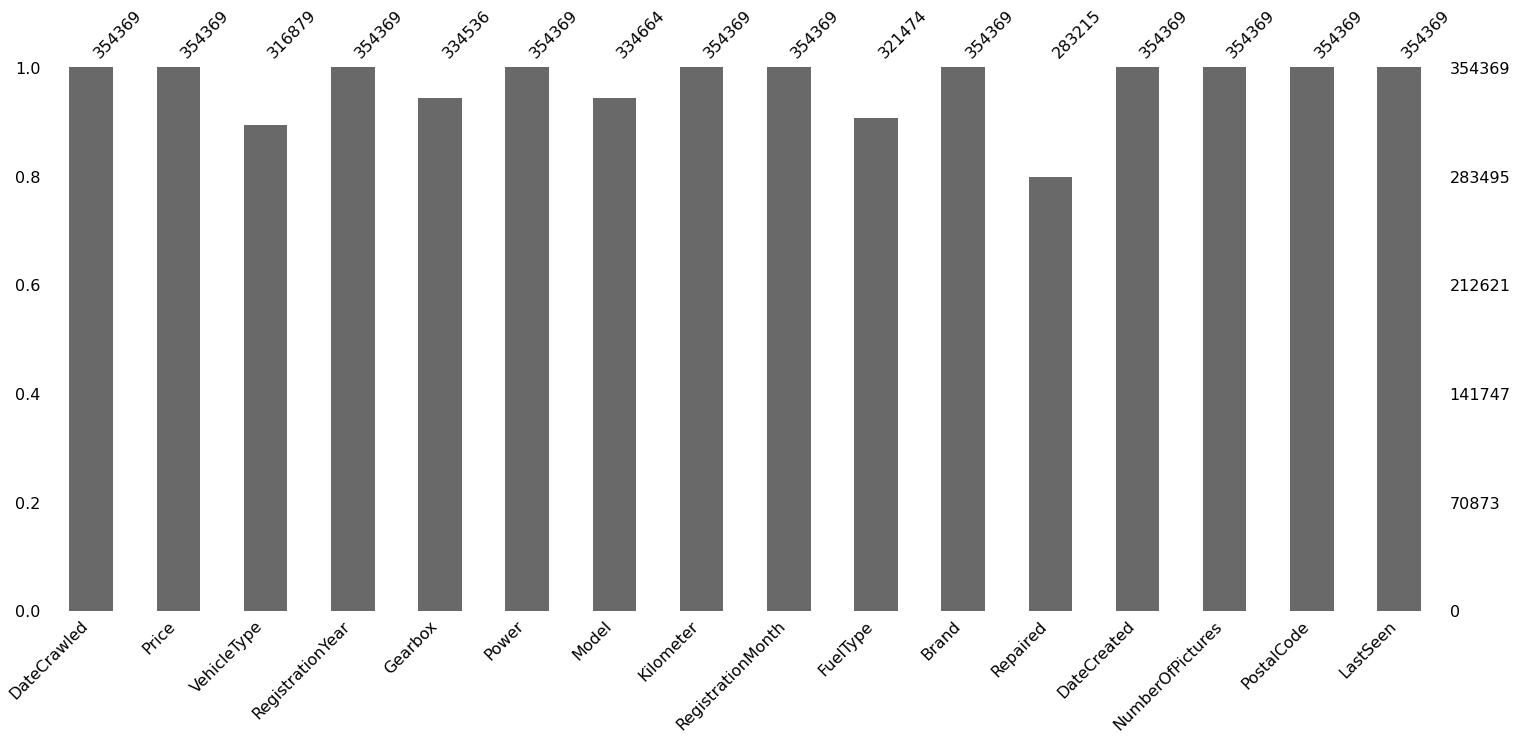

In [9]:
msno.bar(data)
plt.show()

**Пропуски обнаружены в пяти столбцах. Столбцы содержат категориальные данные, поэтому можно организовать заполнение с помощью инструмента SimpleImputer. Данный инструмент заполнит пропуски наиболее частым значение в каждом столбце.**

In [10]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
omissions = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

In [12]:
imputer = SimpleImputer(strategy='most_frequent')

In [13]:
data_train[omissions] = imputer.fit_transform(data_train[omissions])
data_test[omissions] = imputer.transform(data_test[omissions])

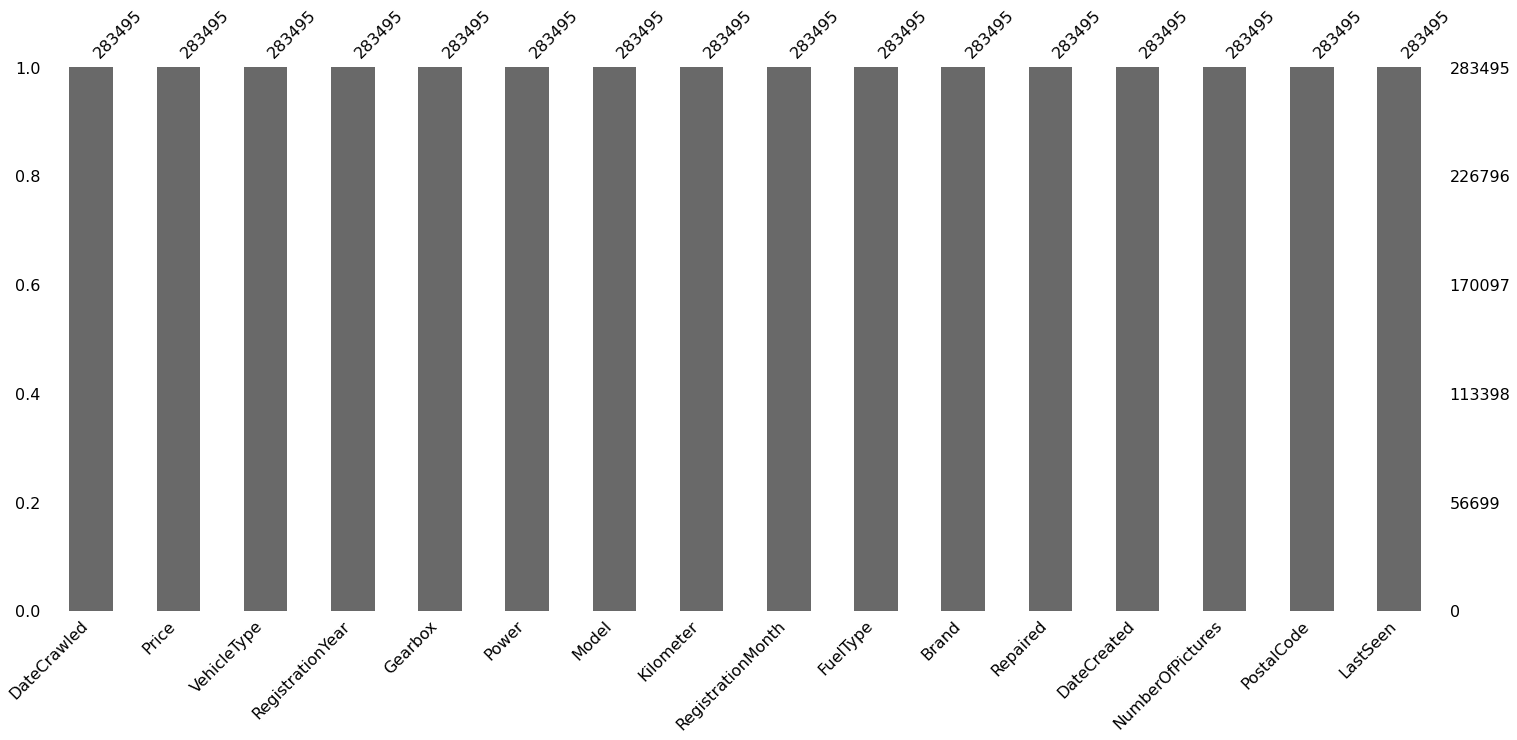

In [14]:
msno.bar(data_train)
plt.show()

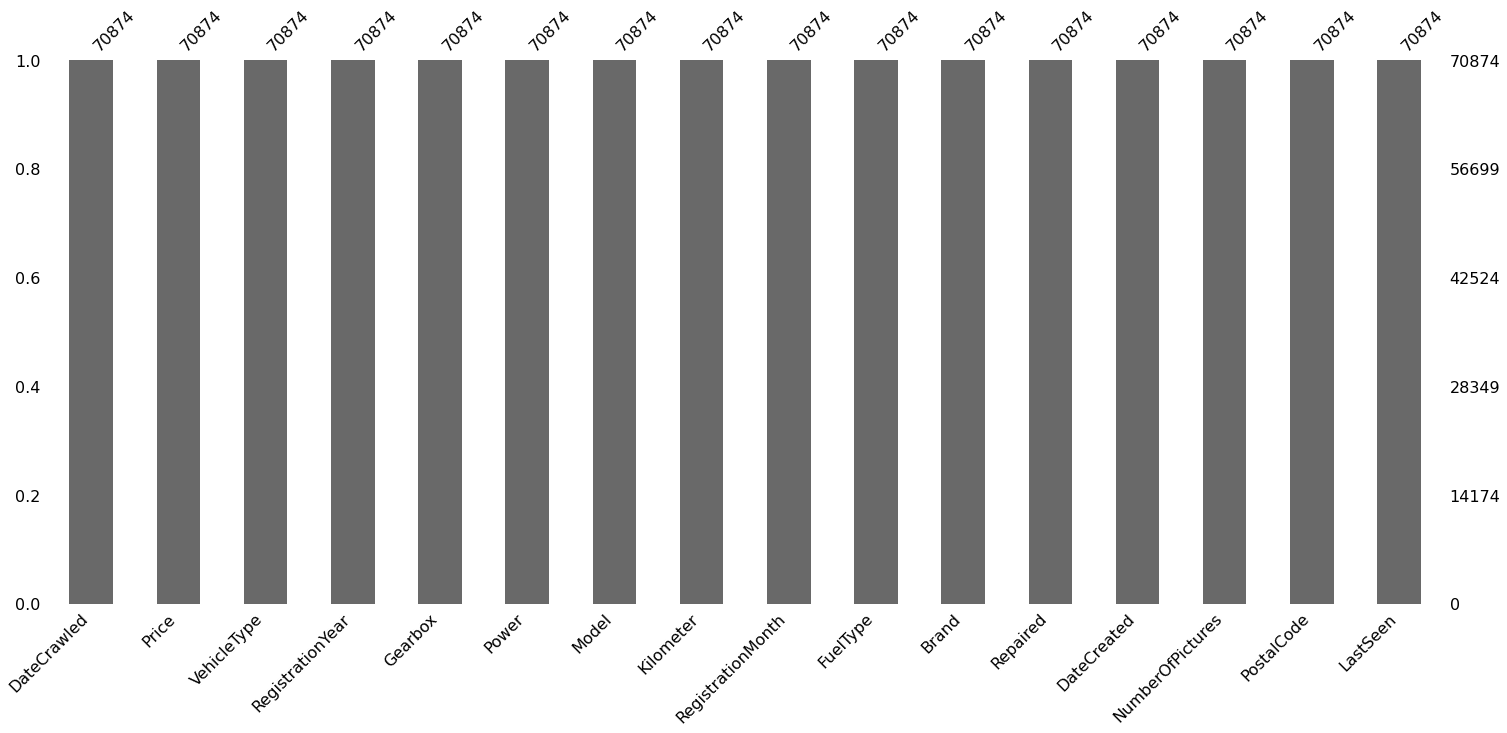

In [15]:
msno.bar(data_test)
plt.show()

**Пропуски корректно заполнены**

### Проверка на дубликаты

In [16]:
print(data_train.duplicated().sum())
data_test.duplicated().sum()

3


0

In [17]:
data_train.shape

(283495, 16)

In [18]:
data_train = data_train.drop_duplicates()

In [19]:
data_train.shape

(283492, 16)

**В данных обнаружены дубликаты в тренировочной выборке, которые можно спокойно удалить.**

### Анализ аномалий и неявных дубликатов

In [20]:
def categorical_features(data, column):
    plt.figure(figsize=(12, 9))
    plt.pie(data[column].value_counts(), labels=data[column].unique(), autopct='%1.1f%%')
    plt.title('Круговая диаграммы столбца ' + column, fontsize=14)
    plt.show()

In [21]:
def numeric_features(data, column, bins):
    plt.figure(figsize=(12, 9))
    plt.hist(data[column], bins = bins)
    plt.xlabel('Значения столбца ' + column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.title('Распределение столбца ' + column, fontsize=14)
    plt.show()

**Две функции, которые будут строить распределение данных в столбце в зависимости от его типа, для категориальных и количественных соответственно.**

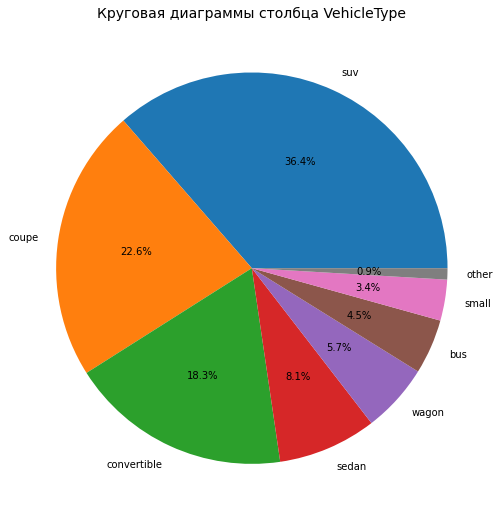

In [22]:
categorical_features(data_train, 'VehicleType')

**Больше всего автомобилей с типом транспортного средства - sedan. Меньше всего автомобилей с типом - wagon, а также некоторые другие.**

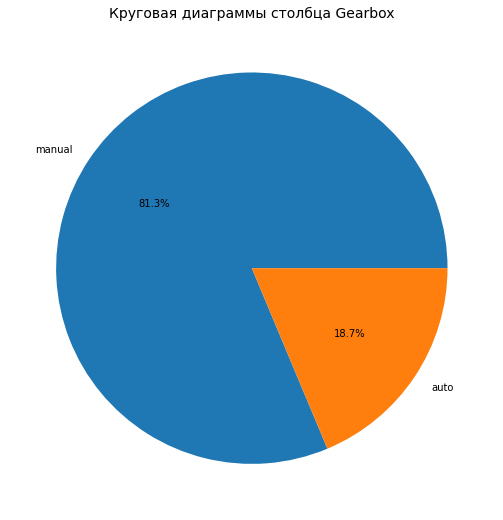

In [23]:
categorical_features(data_train, 'Gearbox')

**Более 80% продаваемых автомобилей имеют механическую коробку передач.**

In [24]:
data_train['Model'].unique().shape

(250,)

**Моделей представлено 250 видов** 

**Ревьюеру(к сожалению, рассмотреть распределение такого количества значений не знаю как показать)**

petrol      199467
gasoline     78847
lpg           4309
cng            444
hybrid         194
other          156
electric        75
Name: FuelType, dtype: int64


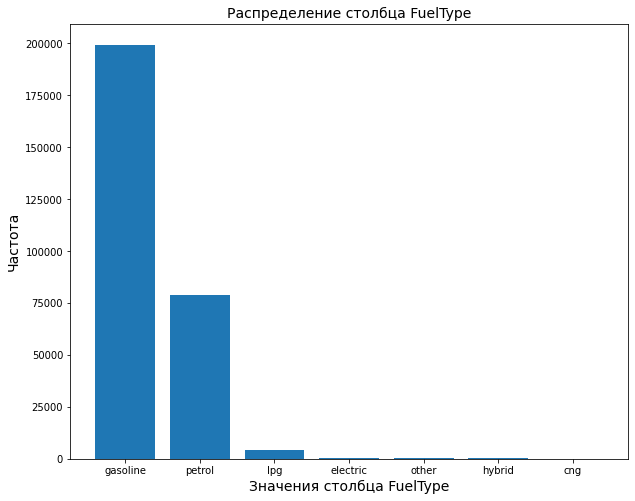

In [25]:
print(data_train['FuelType'].value_counts().sort_values(ascending=False))
plt.figure(figsize=(10, 8))
plt.bar(data_train['FuelType'].unique(), data_train['FuelType'].value_counts().sort_values(ascending=False))
plt.xlabel('Значения столбца FuelType', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Распределение столбца FuelType', fontsize=14)
plt.show()

**Для большинсва автомобилей используют бензин и газ, остальные виды топлива не так популярны.**

In [26]:
data_train['Brand'].unique().shape

(40,)

**Марок автомобилей, выставленных на продажу, составило 40 видов**

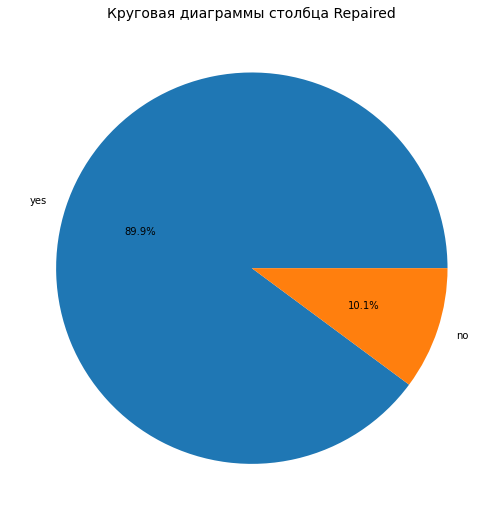

In [27]:
categorical_features(data_train, 'Repaired')

**Почти 90% автомобилей не нуждались в ремонте к моменту продажи.**

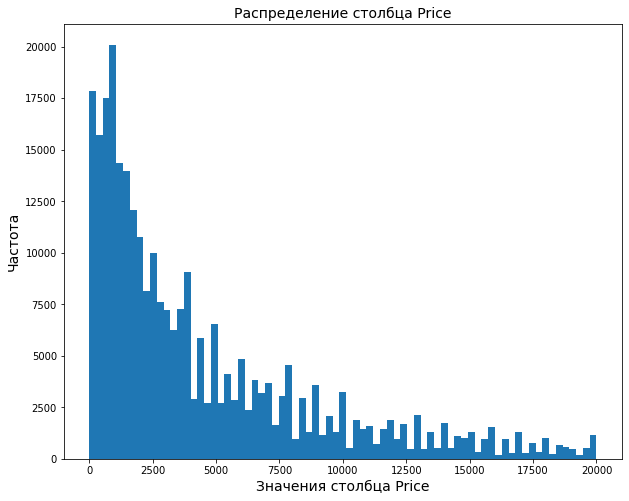

In [28]:
plt.figure(figsize=(10, 8))
plt.hist(data_train['Price'], bins=75)
plt.xlabel('Значения столбца Price', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Распределение столбца Price', fontsize=14)
plt.show()

**Основная масса автомобилей выставлена на продажу со стоимостью до 5000 евро. Но и автмобилей со стоимостью в 20000 евро тоже достаточно.**

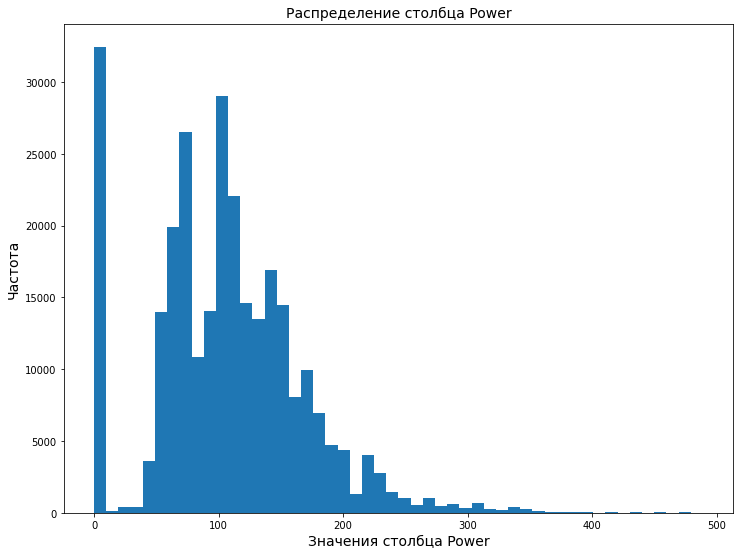

In [29]:
numeric_features(data_train[data_train['Power'] < 500], 'Power', 50)

**Около 40000 экземляров имеют нулевую мощность, но такого не может быть. Данные значения подлежат корректировке.**

In [30]:
data_train['Kilometer'].value_counts()

150000    190688
125000     29112
100000     11857
90000       9262
80000       8078
70000       6886
60000       5966
5000        5090
50000       4999
40000       3895
30000       3561
20000       3122
10000        976
Name: Kilometer, dtype: int64

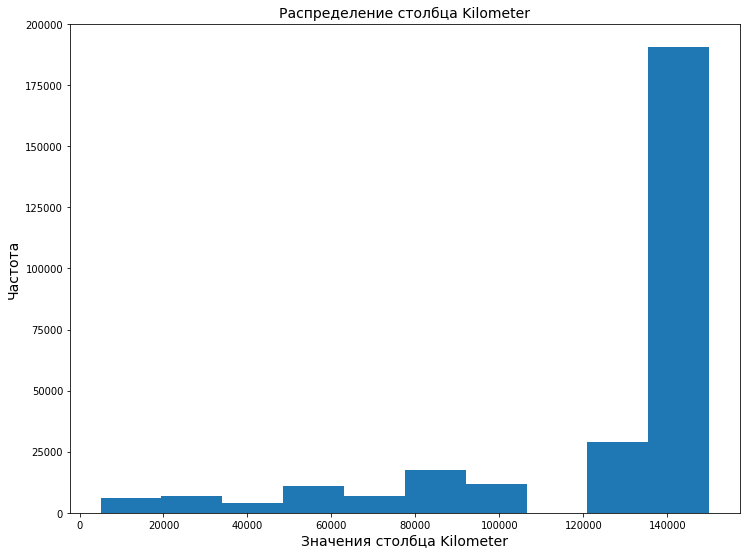

In [31]:
numeric_features(data_train, 'Kilometer', 10)

**Около 240 тыс. автомобилей имеют пробег 150000 км, возможно продажи происходят по мере изношенности.**

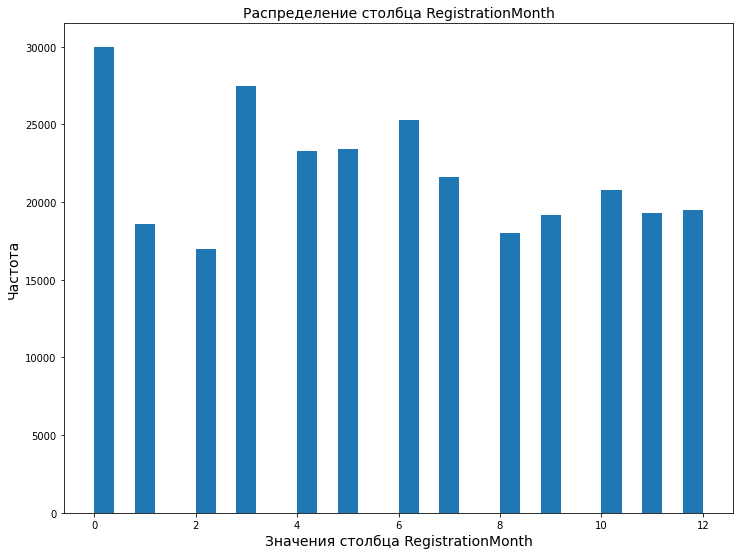

In [32]:
numeric_features(data_train, 'RegistrationMonth', 30)

**Сразу видно наличие как и 0 так и 12 месяца, но скорее всего не корректным значением будет 0 месяц, такие значения нужно будет исправлять. Наибольшую частоту регистрации можно заметить с 3 по 7 месяц, иначе с марта по июль, но особо выраженного фактора сезонности не наблюдается.**

In [33]:
data_train[data_train['NumberOfPictures'] != 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


**Столбец определяющий количество фотографий автомобиля имеет одни 0 и является не информативным, в дальнейшем его можно будет удалить.**

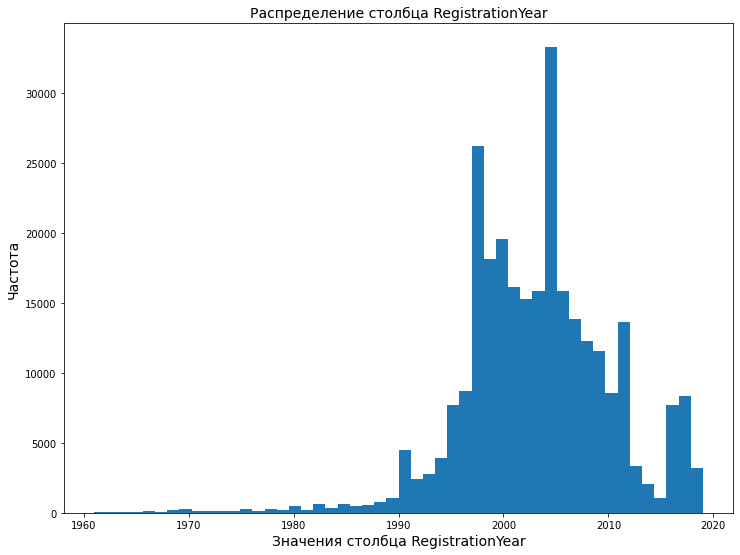

In [34]:
(numeric_features(data_train[(data_train['RegistrationYear'] < 2024) &
                            (data_train['RegistrationYear'] > 1960)], 'RegistrationYear', 50))

In [35]:
data_train[(data_train['RegistrationYear'] > 2024) | (data_train['RegistrationYear'] < 1960)].shape

(427, 16)

**В датасете наблюдаются строки, которые содержат год регистрации автомобиля более действительного года(2024), что является не корректным, сильно давний срок регистрации также можно убрать из датасета в дальнейшем. Чаще всего регистрация происходила с 1995 по 2013 год**

### Анализ признаков содержащих даты

In [36]:
data_train['DateCrawled'] = pd.to_datetime(data_train['DateCrawled'])
data_train['DateCreated'] = pd.to_datetime(data_train['DateCreated'])
data_train['LastSeen'] = pd.to_datetime(data_train['LastSeen'])

**Изменим тип столбцов, которые содержат дату для корректной работы с данными столбцами.**

In [37]:
data_train['DateCrawled'].describe()

count                  283492
unique                 229409
top       2016-03-19 21:49:56
freq                        6
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [38]:
data_d = pd.DataFrame()
data_d['Month'] = data_train['DateCrawled'].dt.month
data_d['Day'] = data_train['DateCrawled'].dt.day_name()

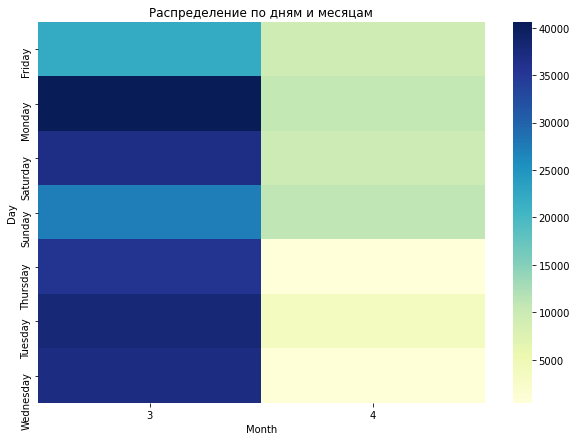

In [39]:
# Построение heatmap по часам и дням
plt.figure(figsize=(10,7))
heatmap_data = data_d.groupby(['Day', 'Month']).size().unstack()
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Распределение по дням и месяцам')
plt.show()

**По выведенной информации о столбце, которые содержит дату скачивания анкеты из базы можно сказать, чаще всего скачивали анкету в понедельник и вторник в марте, реже всего в апреле в среду и четверг.**

In [40]:
data_train['DateCreated'].describe()

count                  283492
unique                    106
top       2016-04-03 00:00:00
freq                    11006
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [41]:
data_d['Month_created'] = data_train['DateCreated'].dt.month
data_d['Day_created'] = data_train['DateCreated'].dt.day_name()

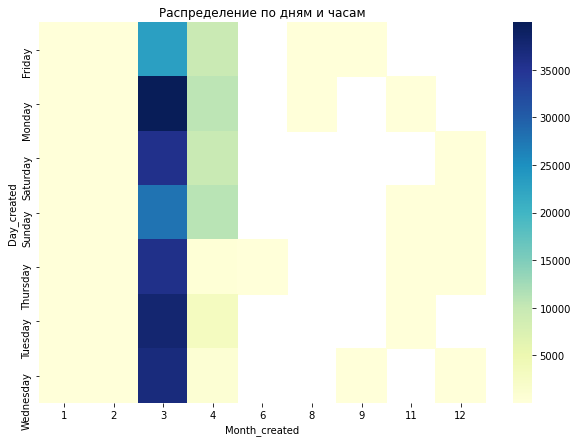

In [42]:
# Построение heatmap по часам и дням
plt.figure(figsize=(10,7))
heatmap_data = data_d.groupby(['Day_created', 'Month_created']).size().unstack()
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Распределение по дням и часам')
plt.show()

**В этой части выведена интерпретация данных о дате создания анкеты. Получаем, что чаще всего создают анкеты в марте во вторник, а реже всего в августе, практические во все дни недели.**

In [43]:
data_train['LastSeen'].describe()

count                  283492
unique                 152368
top       2016-04-06 09:17:58
freq                       16
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

In [44]:
data_d['Month_LastSeen'] = data_train['LastSeen'].dt.month
data_d['Day_LastSeen'] = data_train['LastSeen'].dt.day_name()

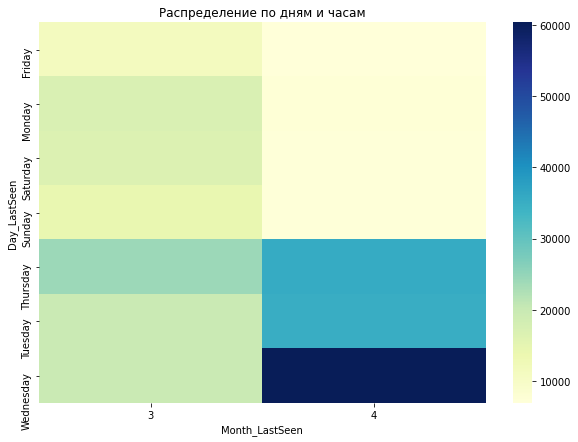

In [45]:
# Построение heatmap по часам и дням
plt.figure(figsize=(10,7))
heatmap_data = data_d.groupby(['Day_LastSeen', 'Month_LastSeen']).size().unstack()
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Распределение по дням и часам')
plt.show()

**Теперь разберем информацию о активностях пользователя в сервисе продаж. В основном последняя активность пользователей была по средам в апреле, а меньше всего также в апреле в субботу, воскресенье, понедельник, пятницу.**

### Корректировка данных

In [46]:
(data_train.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen',
           'DateCreated', 'RegistrationMonth'], axis=1, inplace=True))
(data_test.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen',
           'DateCreated', 'RegistrationMonth'], axis=1, inplace=True))

Удалим не нужные столбцы:


**NumberOfPictures - содержит одни нули, поэтому является не информативным столбцом.**

**PostalCode - почтовый индекс владельца вряд ли может влиять на цену автомобиля**

**DateCrawled, LastSeen, DateCreated  -  представленные даты тоже вряд ли могут влиять на цену автомобиля, цель предсказать которую нам необходимо.**

**RegistrationMonth - так как особой сезонности в регистрации автомобилей мы не увидели, а дистация по годам достаточно большая, то больше информации дадут именно года. а не месяцы. К тому же в данном столбце около 40000 значений с 0 месяцем, удалять нельзя, так как пропадет много строк, поэтому легче избавиться от всего столбца.**

In [47]:
data_train.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
107156,16780,suv,2009,manual,140,tiguan,90000,gasoline,volkswagen,yes
20206,9100,coupe,1987,manual,160,other,150000,petrol,porsche,no
287570,9999,coupe,1968,manual,94,other,30000,petrol,porsche,no
323736,2500,convertible,2001,manual,147,astra,150000,petrol,opel,no
233344,600,sedan,2000,manual,193,5er,150000,petrol,bmw,no


In [48]:
data_test.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
294049,19999,wagon,2014,manual,122,leon,30000,petrol,seat,no
76415,14250,wagon,2011,manual,140,a3,70000,gasoline,audi,no
212563,2850,wagon,2001,manual,131,passat,150000,gasoline,volkswagen,no
109307,50,small,1996,manual,60,corsa,150000,petrol,opel,yes
248545,500,sedan,2016,manual,82,a_klasse,150000,petrol,mercedes_benz,no


In [49]:
#Корректировка признака Power тренировочной выборки
data_train = data_train[data_train['Power'] < 1000]
data_train['Power'] = data_train['Power'].replace(0, data_train[data_train['Power'] != 0]['Power'].mean())
data_train = data_train[data_train['Power'] > 40]
#Корректировка признака Power тестовой выборки
data_test = data_test[data_test['Power'] < 1000]
data_test['Power'] = data_test['Power'].replace(0, data_test[data_test['Power'] != 0]['Power'].mean())
data_test = data_test[data_test['Power'] > 40]

In [50]:
print(data_train.shape)
data_test.shape

(281845, 10)


(70460, 10)

**Оставляем в датафрейме только те автомобили мощность которых меньше 1000 и больше 40 л.с.**

In [51]:
pd.to_datetime(data['DateCrawled']).dt.year.unique()

array([2016])

In [52]:
print(data_train.shape)
data_test.shape

(281845, 10)


(70460, 10)

In [53]:
data_train = data_train[(data_train['RegistrationYear'] < 2016) & (data_train['RegistrationYear'] > 1960)]
data_test = data_test[(data_test['RegistrationYear'] < 2016) & (data_test['RegistrationYear'] > 1960)]

In [54]:
print(data_train.shape)
data_test.shape

(262247, 10)


(65568, 10)

In [55]:
print(data_train[data_train['Price'] == 0].shape)
data_test[data_test['Price'] == 0].shape

(7299, 10)


(1875, 10)

In [56]:
data_train = data_train[data_train['Price'] != 0]
data_test = data_test[data_test['Price'] != 0]

In [57]:
print(data_train.duplicated().sum())
data_test.duplicated().sum()

35631


3122

**После корректировки данных появились дубликаты, удалим их.**

In [58]:
data_train = data_train.drop_duplicates()

In [59]:
shape_end = data_train.shape[0] + data_test.shape[0]
((data.shape[0] - shape_end) / data.shape[0]) * 100

20.136919425796272

### Подготовка данных

In [60]:
#Формирование групп признаков
RANDOM_STATE = 42
num_columns = ['Kilometer', 'Power', 'RegistrationYear']
ohe_columns = ['Repaired', 'Brand', 'FuelType', 'Gearbox', 'VehicleType', 'Model']
ord_columns = ['Repaired', 'Brand', 'FuelType', 'Gearbox', 'VehicleType', 'Model']

**В подготовке данных распределим столбцы по категориям. 3 Количественных или числовых и 6 категориальных, причем в каждом столбце нету значений которые были бы выше рангом чем остальные, все значения имеют одинаковую важность, поэтому используем OneHotEncoder кодирование.**

**Вывод по первому шагу: По итогу данной части проекта данные были полностью подготовлены для обучения моделей. Обработаны пропущенные значения, по диаграммам распределения значений столбцов определены некоторые недостатки данных, много не корректных значений, которые в дальнейшем также были обработаны, путем заполнения средним, либо удалением столбца с месяцем регистрации автомобиля. А также получены срезы данных по столбцам мощности и года регистрации автомобиля.**

## Обучение моделей

In [61]:
X_train, X_test = data_train.drop('Price', axis=1), data_test.drop('Price', axis=1)
y_train, y_test = data_train['Price'], data_test['Price']

In [62]:
ord_columns

['Repaired', 'Brand', 'FuelType', 'Gearbox', 'VehicleType', 'Model']

In [63]:
ord_pipe = Pipeline(
                [('simple_Imputer_before_ord',
                   SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                 ('ord',
                  OrdinalEncoder(categories=[data_train[ord_columns[0]].unique(),
                                             data_train[ord_columns[1]].unique(),
                                             data_train[ord_columns[2]].unique(),
                                             data_train[ord_columns[3]].unique(),
                                             data_train[ord_columns[4]].unique(),
                                             data_train[ord_columns[5]].unique()
                                            ], 
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=np.nan)),
                 ('simple_Imputer_after_ord',
                   SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                ])

In [64]:
data_preprocessor = [ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('ord', ord_pipe, ord_columns)
    ]
), 
                     ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns)
    ]
)]

### Линейная регрессия

In [65]:
pipeline_linear = Pipeline(steps=[
    ('preprocessor', data_preprocessor[1]),
    ('regressor', LinearRegression())
])

In [66]:
rmse_linear = np.sqrt(-cross_val_score(pipeline_linear, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Kilometer', 'Power',
                                                   'RegistrationYear']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Repaired', 'Brand',
                                                   'FuelType', 'Gearbox',
                                                   'VehicleType', 'Model'])])),
                ('regressor', LinearRegression())])

In [68]:
start_train = time()
pipeline_linear.fit(X_train, y_train) 
train_time_linear = (time() - start_train) / 60  

In [69]:
# Замер времени предсказания
start_predict = time()
y_pred_train = pipeline_linear.predict(X_train)  
predict_time_linear = (time() - start_predict) / 60  

In [70]:
# Вывод результатов
print(f"Linear Regression RMSE (CV): {rmse_linear:.4f}")
print(f"Training Time: {train_time_linear:.4f} minutes")
print(f"Prediction Time on Train: {predict_time_linear:.4f} minutes")

Linear Regression RMSE (CV): 2689.9358
Training Time: 0.4448 minutes
Prediction Time on Train: 0.0246 minutes


### Модель Ridge

In [71]:
pipeline = Pipeline(steps=[
    ('preprocessor', data_preprocessor[1]),
    ('regressor', Ridge())
])

In [72]:
param_ridge = {
    'regressor__alpha': [0.3, 0.5, 0.7, 1],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

In [76]:
ridge_gs = (RandomizedSearchCV(pipeline, param_ridge, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, random_state=RANDOM_STATE))
ridge_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Kilometer',
                                                                                'Power',
                                                                                'RegistrationYear']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['Repaired',
                                                                                'Brand',
                                                                                'FuelType',
                                                                                'Gearbox',
                                                                                'VehicleType',
                                                                                'Model'])])),
                                             ('regressor', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'regressor__alpha': [0.3, 0.5, 0.7, 1],
                                        'regressor__solver': ['auto', 'svd',
                                                              'cholesky',
                                                              'lsqr']},
                   random_state=42, scoring='neg_mean_squared_error')

In [77]:
start = time()
ridge_gs.best_estimator_.fit(X_train, y_train)
train_time_ridge = (time() - start) / 60
rmse_ridge = np.sqrt(-ridge_gs.best_score_)

In [78]:
# Замер времени предсказания
start_predict = time()
y_pred_train = ridge_gs.predict(X_train)  
predict_time_ridge = (time() - start_predict) / 60  

In [79]:
# Вывод результатов
print(f"Linear Regression RMSE (CV): {rmse_ridge:.4f}")
print(f"Training Time: {train_time_ridge:.4f} minutes")
print(f"Prediction Time on Train: {predict_time_ridge:.4f} minutes")

Linear Regression RMSE (CV): 2689.8601
Training Time: 0.0613 minutes
Prediction Time on Train: 0.0250 minutes


### Градиентный бустинг

In [80]:
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', data_preprocessor[0]),
    ('regressor', lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1))
])

In [81]:
# Гиперпараметры для LightGBM
param_random_lgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [2, 5],
    'regressor__num_leaves': [10, 20],
    'regressor__boosting_type': ['gbdt', 'dart', 'goss']
}

In [82]:
# Подбор гиперпараметров для LGBMRegressor
lgbm_gs = (RandomizedSearchCV(estimator=lgb_pipeline, param_distributions=param_random_lgb,
                                       cv=5, random_state=RANDOM_STATE))
lgbm_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Kilometer',
                                                                                'Power',
                                                                                'RegistrationYear']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_Imputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[array(['yes', 'no'], dtype=object),
                                                                                                                           array(['volkswagen', 'porsc...
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['Repaired',
                                                                                'Brand',
                                                                                'FuelType',
                                                                                'Gearbox',
                                                                                'VehicleType',
                                                                                'Model'])])),
                                             ('regressor',
                                              LGBMRegressor(objective='regression',
                                                            random_state=42))]),
                   param_distributions={'regressor__boosting_type': ['gbdt',
                                                                     'dart',
                                                                     'goss'],
                                        'regressor__max_depth': [2, 5],
                                        'regressor__n_estimators': [100, 200],
                                        'regressor__num_leaves': [10, 20]},
                   random_state=42)

In [83]:
start = time()
lgbm_gs.best_estimator_.fit(X_train, y_train)
train_time_lgbm = (time() - start) / 60
rmse_lgbm = np.sqrt(lgbm_gs.best_score_)

In [84]:
# Замер времени предсказания
start_predict = time()
y_pred_train = lgbm_gs.predict(X_train)  
predict_time_lgbm = (time() - start_predict) / 60  

In [85]:
# Вывод результатов
print(f"Linear Regression RMSE (CV): {rmse_lgbm:.4f}")
print(f"Training Time: {train_time_lgbm:.4f} minutes")
print(f"Prediction Time on Train: {predict_time_lgbm:.4f} minutes")

Linear Regression RMSE (CV): 0.9201
Training Time: 0.1850 minutes
Prediction Time on Train: 0.0305 minutes


### Модель Dummy 

In [86]:
dummy_pipeline = Pipeline(steps=[
    ('preprocessor', data_preprocessor[0]), 
    ('regressor', DummyRegressor())  
])
start = time()
dummy_pipeline.fit(X_train, y_train)  # Обучаем модель на тренировочной выборке
train_time_dummy = (time() - start) / 60  # Время обучения
y_pred_dummy = dummy_pipeline.predict(X_test)

start_predict = time()
y_pred_train = dummy_pipeline.predict(X_train)  
predict_time_dummy = (time() - start_predict) / 60  
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))

In [87]:
# Вывод результатов
print(f"Linear Regression RMSE (CV): {rmse_dummy:.4f}")
print(f"Training Time: {train_time_dummy:.4f} minutes")
print(f"Prediction Time on Train: {predict_time_dummy:.4f} minutes")

Linear Regression RMSE (CV): 4597.6585
Training Time: 0.0093 minutes
Prediction Time on Train: 0.0066 minutes


**Вывод по 2 шагу: По итогу данного шага было обучено 3 модели Линейная регрессия, Ridge и модель градиентного бустинга, использованы несколько видов гиперпараметров для 2 и 3 модели. В ходе проверки на тестовой выборке получили, что только бустинговая модель достигла практически нулевого отклонения на кросс-валидации равным 0.92. Особенным параметром был boosting_type, которые определял тип бустинга. Пайпалайн показал, что лучшим типом был goss. Тип основанный на сокращении используемых данных, фокусируясь на наиболее значимых примерах. Проведено сравнение моделей с Dummy регрессором, результат работы этой модели также будет добавлен в итоговую таблицу и учтен при сравнении.**

## Анализ моделей

In [88]:
results = {
    'Model': ['Linear Regression', 'Ridge', 'LGBMRegressor'],
    'RMSE': [rmse_linear, rmse_ridge, rmse_lgbm],
    'Training Time (min)': [train_time_linear, train_time_ridge, train_time_lgbm],
    'Pridict Time(Train data)': [predict_time_linear, predict_time_ridge, predict_time_lgbm]
}

df_results = pd.DataFrame(results)
df_results

,Model,RMSE,Training Time (min),Pridict Time(Train data)
0,Linear Regression,2689.935811,0.444776,0.024629
1,Ridge,2689.860120,0.061309,0.024990
2,LGBMRegressor,0.920146,0.185026,0.030470


In [89]:
best_model = lgbm_gs.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [90]:
# Оценка RMSE на тестовой выборке
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse_test:.4f}")

Test RMSE: 1797.8873


**Итоги третьего шага(результаты кросс-валидации):  У заказчика было 3 критерия:**
 - качество 
 - время обучения 
 
Ознакомиться с результатами работы моделей можно в итоговой таблице `df_results`.

 Таким образом, можно сказать, что в данном случае почти 11 минут у Бустинга выглядит намного больше, чем те же 2 минуты у обычной линейной регрессии, но качество у бустинга на кросс-валидации rmse = 0.92, что очень хороший показатель. На тестовой выборке была задача, чтобы RMSE не превышала 2500, у бустинговой модели получилось достичь результата в 1797, что удовлетворяет условию. Намного точнее можно  предсказать цену автомобиля Бустингом. Тем самым цены автомобилям будут утверждаться  по соответствию их характеристикам, поэтому заказчику рекомендуется использовать модель LGBMRegressor(boosting_type='goss', max_depth=5, n_estimators=200, num_leaves=20,objective='regression', random_state=42) с соответствующими параметрами.

## Итоговый вывод по проекту

В ходе выполнения проекта были выполнены следующие шаги:

 - Загрузка необходимых библиотек и загрузка самих данных.

 - Предобработка данных включала в себя: 
      - Заполнение пропущенных значений с помощью SimpleImputer, который заполнил пропуски в категориальных признаках наиболее часто встречающимся значением;
      - Было обнаружено 5 дубликатов, которые были удалены;
      - Обработка аномальных значений: в столбце с мощностью автомобиля имелись нулевые значения, которые были заполнены средний значение по столбцу, без учета этих самых нулевых значений, год регистрации автомобиля был указан далеко за 2016 год, поэтому был получен срез данных, где мы ограничились промежутком времени от 1960 по 2016 год - года выгрузки анкет с сервиса;
      - Удалены столбцы:
        - NumberOfPictures - содержит одни нули, поэтому является не информативным столбцом.

        - PostalCode - почтовый индекс владельца вряд ли может влиять на цену автомобиля

        - DateCrawled, LastSeen, DateCreated  -  представленные даты тоже вряд ли могут влиять на цену автомобиля, цель предсказать которую нам необходимо.

        - RegistrationMonth - так как особой сезонности в регистрации автомобилей мы не увидели, а дистация по годам достаточно большая, то больше информации дадут именно года. а не месяцы. К тому же в данном столбце около 40000 значений с 0 месяцем, удалять нельзя, так как пропадет много строк, поэтому легче избавиться от всего столбца.
        - После всех окончательных манипуляций и удалений столбцов появились дубликаты снова, которые также были удалены.
 - Подготовка данных: 
     - Столбцы были распределены на категориальные  и количественные для дальнейшего корректного кодирования;
     - Создан трансформер, которые будет преобразовывать соответствующие признаки при обучении.
 - Обучение : По итогу данного шага было обучено 3 модели Линейная регрессия, Ridge и модель градиентного бустинга, использованы несколько видов гиперпараметров для 2 и 3 модели. В ходе проверки на тестовой выборке получили, что только бустинговая модель достигла практически нулевого отклонения на кросс-валидации равным 0.92. Особенным параметром был boosting_type, которые определял тип бустинга. Пайпалайн показал, что лучшим типом был goss. Тип основанный на сокращении используемых данных, фокусируясь на наиболее значимых примерах. Проведено сравнение моделей с Dummy регрессором, результат работы этой модели также будет добавлен в итоговую таблицу и учтен при сравнении.
 
 - Анализ моделей:
 
**Важными параметрами оценки модели были**:
 - качество 
 - время обучения 
 
Ознакомиться с результатами работы моделей можно в итоговой таблице `df_results`.

 Таким образом, можно сказать, что в данном случае почти 11 минут у Бустинга выглядит намного больше, чем те же 2 минуты у обычной линейной регрессии, но качество у бустинга на кросс-валидации rmse = 0.92, что очень хороший показатель. На тестовой выборке была задача, чтобы RMSE не превышала 2500, у бустинговой модели получилось достичь результата в 1797, что удовлетворяет условию. Намного точнее можно  предсказать цену автомобиля Бустингом. Тем самым цены автомобилям будут утверждаться  по соответствию их характеристикам, поэтому заказчику рекомендуется использовать модель LGBMRegressor(boosting_type='goss', max_depth=5, n_estimators=200, num_leaves=20,objective='regression', random_state=42) с соответствующими параметрами.